## The problem
$\|w\|_1\to\min$ s.t. $\|wX-y\|_2^2\leq\varepsilon$

The Lagrangian is:
$$
L(w, \lambda)=\|w\|_1+\lambda(\|wX-y\|_2^2-\varepsilon)
$$

Gradients are:
$$
\frac{\partial L}{\partial w}=\frac{\partial}{\partial w} \left[\|w\|_1+\lambda \|wX-y\|_2^2\right]
$$

and 
$$
\frac{\partial L}{\partial \lambda}=\|wX-y\|_2^2-\varepsilon
$$

They correspond to minimizing functions $L(w, \lambda)$ over $w$ and $-L(w, \lambda)$ over $\lambda$.

In [1]:
import torch
import gin
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
device = torch.device('cuda')

In [3]:
data = torch.randn(1000, 10).to(device).detach()

In [4]:
y = (data[:, 0] + data[:, -1]).detach()

In [5]:
w = torch.autograd.Variable(torch.randn(10).to(device), requires_grad=True)
lam = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)

In [6]:
def fit():
    return ((y - w @ data.T).pow(2).sum(0))

def sp():
    return w.abs().sum()

def lagrangian(sp_, fit_):
    return sp_ + lam.mean() * (fit_ - 0.0001)

In [7]:
lam.mean(), fit().item(), sp().item(), lagrangian(sp(), fit())

(tensor(0.5494, device='cuda:0', grad_fn=<MeanBackward0>),
 13419.1435546875,
 7.097525119781494,
 tensor(7380.0820, device='cuda:0', grad_fn=<AddBackward0>))

In [8]:
opt_primal = torch.optim.Adam([w], lr=1e-3)
opt_dual = torch.optim.SGD([lam], lr=1e-3)

In [9]:
lags = []
fits = []
sps = []
lams = []

In [10]:
for i in tqdm(range(10000)):
    opt_primal.zero_grad()
    sp_ = sp()
    fit_ = fit()
    l = lagrangian(sp_, fit_)
    l.backward()
    opt_primal.step()
    
    lags.append(l.item())
    fits.append(fit_.item())
    sps.append(sp_.item())
    lams.append(lam.item())

    
    opt_dual.zero_grad()
    sp_ = sp()
    fit_ = fit()
    l = -lagrangian(sp_, fit_)
    l.backward()
    opt_dual.step()
        
    lam.data[:] = torch.clamp(lam.data, 0, 100000)

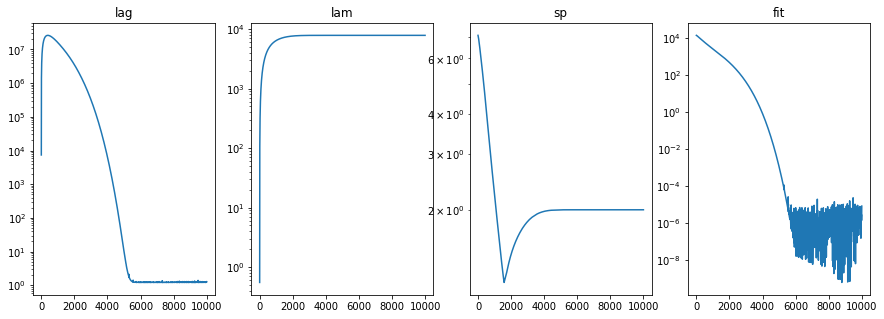

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title('lag')
plt.plot(lags)
plt.yscale('log')

plt.subplot(1, 4, 2)
plt.title('lam')
plt.plot(lams)
plt.yscale('log')

plt.subplot(1, 4, 3)
plt.title('sp')
plt.plot(sps)
plt.yscale('log')

plt.subplot(1, 4, 4)
plt.title('fit')
plt.plot(fits)
plt.yscale('log')

<AxesSubplot:>

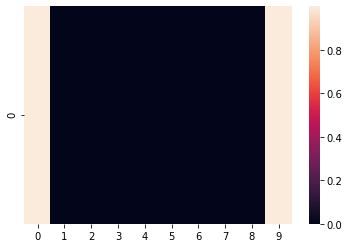

In [12]:
sns.heatmap(w.cpu().detach().numpy().reshape(1, -1))

In [13]:
w.grad

tensor([ -157.9464,    17.6461,  -108.2907,  1930.0308,   920.1009, -1820.8687,
           21.8923,  -121.5771,   970.7625,   169.3469], device='cuda:0')

In [14]:
lam.grad

tensor([9.0497e-05], device='cuda:0')

In [15]:
w

tensor([ 1.0000e+00, -8.2616e-09,  1.1025e-07, -6.2347e-05, -3.2272e-05,
         5.9192e-05, -4.1748e-08,  2.5542e-08, -3.3134e-05,  1.0000e+00],
       device='cuda:0', requires_grad=True)

In [16]:
lam

tensor([7857.9463], device='cuda:0', requires_grad=True)